In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

import pycollocation

<h1>Textbook example: Ramsey-Cass-Koopmans model</h1>

<h2> Household behavior </h2>

Suppose that there exist a representative household with the following lifetime utility...

$$U \equiv \int_{t=0}^{\infty} e^{-\rho t}u(c(t))\frac{N(t)}{H}dt$$

...where the flow utility function $u(C(t))$ is assumed to be a concave function of per capita consumption, $c(t)$. Note that $N(t)$, the size of the household, is assumed to grow at a constant and exogenous rate $n$: 

$$ N(t) = N(0)e^{nt}.$$

At each instant in time, the representative household faces the following budget constraint...

$$\dot{K}(t) = r(t)K(t) + W(t)lN(t) - P(t)c(t)N(t)$$

...where $r(t)$ is the real interest rate, $K(t)$ is the total amount of household capital; $W(t)$ is the real wage paid for labor, $l$ is the household's labor endowment; $P(t)$ is the price level of the consumption good (which we are free to normalize to 1 for convenience).

<h3> Solution to the household problem </h3>

Form the Hamiltonian...

$$ H(t, K, c, \lambda) \equiv e^{-\rho t}u(c(t))N(t) + \lambda(t)\bigg[r(t)K(t) + W(t)lN(t) - c(t)N(t)\bigg] $$

...differentiate with respect to control variables $c$ and the state variable $K$...

\begin{align}
    \frac{\partial H}{\partial c} \equiv& e^{-\rho t}\frac{\partial u}{\partial c}N(t) - \lambda(t)N(t) \\
    \frac{\partial H}{\partial K} \equiv& r(t)\lambda(t)
\end{align}

...the state and co-state equations are...

\begin{align}
    \dot{K}(t) = \frac{\partial H}{\partial \lambda} =& r(t)K(t) + W(t)lN(t) - c(t)N(t) \\
    \dot{\lambda} = -\frac{\partial H}{\partial K} =& -r(t)\lambda(t)\\
\end{align}

<h4> Derivation of the Euler equation </h4>
From first-order condition for $c$ we have that...

$$ e^{-\rho t}\frac{\partial u}{\partial c}=\lambda(t) $$

...differentiate with respect to time...

$$ -\rho e^{-\rho t}\frac{\partial u}{\partial c} + e^{-\rho t}\frac{\partial^2 u}{\partial c^2}\dot{c}(t)=\dot{\lambda}(t)$$

...using the co-state equation we can write...

$$ -\rho e^{-\rho t}\frac{\partial u}{\partial c} + e^{-\rho t}\frac{\partial^2 u}{\partial c^2}\dot{c}(t)=-r(t)\lambda(t)$$

...using the first-order condition again we can write...

$$ -\rho e^{-\rho t}\frac{\partial u}{\partial c} + e^{-\rho t}\frac{\partial^2 u}{\partial c^2}\dot{c}(t)=-r(t)e^{-\rho t}\frac{\partial u}{\partial c}$$

...finally, after a bit of algebra we find that the consumption behavior of the representative household is described by the following Euler equation...

$$ \frac{\dot{c}(t)}{c(t)} = \frac{1}{RRA(c(t))}\bigg[r(t) - \rho\bigg] $$

...where...

$$ RRA(c(t)) = -\frac{c\frac{\partial^2 u}{\partial c^2}}{\frac{\partial u}{\partial c}}$$

...is the <a href="https://en.wikipedia.org/wiki/Risk_aversion">Pratt-Arrow measure of relative risk aversion</a>. Consumption Euler equation says that consumption growth is proportional to the gap between the real interest rate $r(t)$ and the discount rate $\rho$; and inversely proportional to risk preferences.

<h2>Firm behavior</h2>

Inputs to production are capital, $K$, labor, $L$, and technology, $A$. Representative firm has a production function, $F$, that is homogenous of degree 1...

\begin{equation}
    Y(t) = F\bigg(A(t), K(t), L(t)\bigg)
\end{equation}

...note that technology, $A$, is assumed to grow at a constant, exogenous rate $g$

$$ A(t) = A(0)e^{gt}. $$

Firms choose demands for $K$ and $L$ in order to maximise profits...

\begin{align}
    \Pi(t) =& P(t)Y(t) - (r(t) + \delta)K(t) - W(t)L(t) \\
    =& F\bigg(A(t), K(t), L(t)\bigg) - (r(t) + \delta)K(t) - W(t)L(t) 
\end{align}
	
Standard assumptions of perfect competition in factor markets as well as the production of output goods implies that inputs to production are paid their marginal products.  Thus the real interest rate $r(t)$ and the wage, $W(t)$ are...

\begin{align}
    r(t) =& \frac{\partial F}{\partial K} - \delta \\
    W(t) =& \frac{\partial F}{\partial L}.
\end{align}

Note that our homogeneity assumption on $F$ combined with <a href="https://en.wikipedia.org/wiki/Homogeneous_function">Euler's other theorem</a> are enough to insure that the representative firm earns zero profit...

$$ \Pi(t) = F\bigg(A(t), K(t), L(t)\bigg) - \bigg[K\frac{\partial F}{\partial K} + L\frac{\partial F}{\partial L}\bigg] = 0. $$

<h2> Market clearing equilibrium </h2>

Impose market clearing equilibrium assumption for capital and labor markets. In particular note that...

$$ \text{labor demand} \equiv L(t) = lN(t) \equiv \text{labor supply}. $$

Assumption that factor markets clear allows us to combine household and firm behavior to get a system of ordinary differential equations...

\begin{align}
    \dot{c}(t) =& \frac{1}{ARA(c(t))}\bigg[\frac{\partial F}{\partial K} - \delta - \rho\bigg] \\
    \dot{K}(t) =& F\bigg(A(t), K(t), lN(t)\bigg) - \delta K(t) - c(t)N(t) \\
\end{align}

...where...

$$ ARA(c(t)) = -\frac{\frac{\partial^2 u}{\partial c^2}}{\frac{\partial u}{\partial c}}$$

...is the <a href="https://en.wikipedia.org/wiki/Risk_aversion">Pratt-Arrow measure of absolute risk aversion</a>.


<h2> De-trending the model </h2>

Recall that technology and household size (i.e., population!) are growing at exogenous rates.  Want to de-trend the model so that we can analyze fixed point equilibrium of the dynamical system.

Homogeneity assumption on $F$ tells us that...

$$\frac{1}{A(t)N(t)}F\bigg(A(t), K(t), lN(t)\bigg) = F\bigg(1, \frac{K(t)}{A(t)N(t)}, l\bigg) = f(k(t)) $$

...and...

$$ \frac{\partial F}{\partial K} = \frac{\partial F}{\partial K}\bigg(1, \frac{K(t)}{A(t)N(t)}, l\bigg) = \frac{\partial f}{\partial k} = f'(k(t)) $$

...where...

$$ k(t) = \frac{K(t)}{A(t)N(t)} $$

...is now defined to be capital per unit effective labor supply. Similarly we can de-trend per capita consumption $c(t)$ using the following change of variables...

\begin{align}
    c(t) =& A(t)\tilde{c}(t) \\
    \dot{c} =& \dot{A}(t)\tilde{c}(t) + A(t)\dot{\tilde{c}}(t).
\end{align}

Using these results, we can re-write the above system of differential equations as follows...

\begin{align}
    \dot{k}(t) =& f(k(t)) - (g + n + \delta)k(t) - \tilde{c}(t)\\
    \dot{\tilde{c}}(t) =& \frac{1}{A(0)e^{gt}ARA\bigg(A(0)e^{gt}\tilde{c}(t)\bigg)}\bigg[f'(k(t)) - \delta - \rho\bigg] - g\tilde{c}(t)
\end{align}

...where $k$ and $c$ are now measured per unit of effective labor supply. Note that the equation of motion for consumption per unit effective labor supply is no longer time invariant. However, if marginal utility of consumption for the representative household is homogenous of degree $k$, then the equation of motion for $\tilde{c}$ becomes <a href="https://en.wikipedia.org/wiki/Autonomous_system_(mathematics)">time-invariant</a>...

\begin{align}
    \dot{\tilde{c}}(t) =& \frac{1}{ARA\bigg(\tilde{c}(t)\bigg)}\bigg[f'(k(t)) - \delta - \rho\bigg] - g\tilde{c}(t)
\end{align}

<h2> Boundary conditions </h2>

To complete the model we need to specifcy some boundary conditions. The initial conditions for technology, $A(0)$, and household size (i.e., population), $N(0)$, and capital, $K(0)$, are assumed given. Therefore...

$$ k(0) = \frac{K(0)}{A(0)N(0)}. $$

We will impose the following terminal condition on consumption per unit effective labor supply...

$$ \lim_{t \rightarrow \infty} \tilde{c}(t) = \tilde{c}^*. $$

<h2> Full model </h2>

The full model is completely specified by the following system of ordinary conditions and boundary conditions...

\begin{align}
    \dot{k}(t) =& f(k(t)) - (g + n + \delta)k(t) - \tilde{c}(t),\ k(0) = k_0 \\
        \dot{\tilde{c}}(t) =& \frac{1}{A(0)e^{gt}ARA\bigg(A(0)e^{gt}\tilde{c}(t)\bigg)}\bigg[f'(k(t)) - \delta - \rho\bigg] - g\tilde{c}(t),\ \lim_{t \rightarrow \infty} \tilde{c}(t) = c^*
\end{align}

<h2> Example: HARA risk aversion and Cobb-Douglas production</h2>

In [5]:
def hara(t, c, A0, g, a, b, **params):
    """
    Hyperbolic Absolute Risk Aversion (HARA).
    
    Notes
    -----
    For Constant Absolute Risk Aversion (CARA), set a=0; for
    Constant Relative Risk Aversion (CRRA), set b=0.

    """
    return 1 / (a * c + b)


def cobb_douglas_output(k, alpha, l, **params):
    return k**alpha * l**(1 - alpha)


def cobb_douglas_mpk(k, alpha, l, **params):
    return alpha * k**(alpha - 1) * l**(1 - alpha)


def c_tilde_dot(t, k, c_tilde, A0, delta, g, rho, **params):
    r = cobb_douglas_mpk(k, **params) - delta
    return ((r - rho) / (A0 * np.exp(g * t) * hara(t, A0 * np.exp(g * t) * c_tilde, A0, g, **params))) - g * c_tilde


def k_dot(t, k, c_tilde, delta, g, n, **params):
    return cobb_douglas_output(k, **params) - c_tilde - (g + n + delta) * k


def standard_ramsey_model(t, k, c_tilde, A0, delta, g, n, rho, **params):
    out = [k_dot(t, k, c_tilde, delta, g, n, **params),
           c_tilde_dot(t, k, c_tilde, A0, delta, g, rho, **params)]
    return out


def initial_condition(t, k, c_tilde, A0, K0, N0, **params):
    return [k - (K0 / (A0 * N0))]


def terminal_condition(t, k, c_tilde, **params):
    return [c_tilde - equilibrium_consumption(**params)]


def equilibrium_capital(a, alpha, b, delta, g, l, n, rho, **params):
    return ((a * alpha * l**(1 - alpha)) / (a * (delta + rho) + g))**(1 / (1 - alpha))


def equilibrium_consumption(a, alpha, b, delta, g, l, n, rho, **params):
    kss = equilibrium_capital(a, alpha, b, delta, g, l, n, rho)
    return cobb_douglas_output(kss, alpha, l) - (g + n + delta) * kss


To complete the model we need to define some parameter values.

In [6]:
# set b=0 for CRRA...
params = {'a': 1.0, 'b': 0.0, 'g': 0.02, 'n': 0.02, 'alpha': 0.15,
          'delta': 0.04, 'l': 1.0, 'K0': 1.0, 'A0': 1.0, 'N0': 1.0,
          'rho': 0.02}

<h2>Solving the model with pyCollocation</h2>

<h3>Defining a `pycollocation.TwoPointBVP` instance</h3>

In [7]:
pycollocation.problems.TwoPointBVP?

In [8]:
standard_ramsey_bvp = pycollocation.problems.TwoPointBVP(bcs_lower=initial_condition,
                                                         bcs_upper=terminal_condition,
                                                         number_bcs_lower=1,
                                                         number_odes=2,
                                                         params=params,
                                                         rhs=standard_ramsey_model,
                                                         )

### Finding a good initial guess for $k(t)$

Theory tells us that, starting from some initial condition $k_0$, the solution to the Solow model converges monotonically toward its long run equilibrium value $k^*$. Our initial guess for the solution should preserve this property...

In [9]:
def initial_mesh(t, T, num, problem):
    # compute equilibrium values
    cstar = equilibrium_consumption(**problem.params)
    kstar = equilibrium_capital(**problem.params)
    ystar = cobb_douglas_output(kstar, **problem.params)

    # create the mesh for capital
    ts = np.linspace(t, T, num)
    k0 = problem.params['K0'] / (problem.params['A0'] * problem.params['N0'])
    ks = kstar - (kstar - k0) * np.exp(-ts)

    # create the mesh for consumption
    s = 1 - (cstar / ystar)
    y0 = cobb_douglas_output(k0, **problem.params)
    c0 = (1 - s) * y0
    cs = cstar - (cstar - c0) * np.exp(-ts)

    return ts, ks, cs


### Solving the model

In [8]:
pycollocation.solvers.Solver?

<h3> Polynomial basis functions </h3>

In [12]:
polynomial_basis = pycollocation.basis_functions.PolynomialBasis()
solver = pycollocation.solvers.Solver(polynomial_basis)

boundary_points = (0, 200)
ts, ks, cs = initial_mesh(*boundary_points, num=1000, problem=standard_ramsey_bvp)

basis_kwargs = {'kind': 'Chebyshev', 'domain': boundary_points, 'degree': 25}
k_poly = polynomial_basis.fit(ts, ks, **basis_kwargs)
c_poly = polynomial_basis.fit(ts, cs, **basis_kwargs)
initial_coefs = np.hstack([k_poly.coef, c_poly.coef])
nodes = polynomial_basis.roots(**basis_kwargs)

solution = solver.solve(basis_kwargs, boundary_points, initial_coefs,
                        nodes, standard_ramsey_bvp)


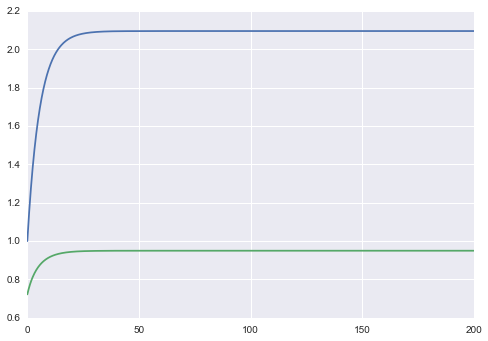

In [13]:
ts, _, _ = initial_mesh(*boundary_points, 1000, standard_ramsey_bvp)
k_soln, c_soln = solution.evaluate_solution(ts)
plt.plot(ts, k_soln)
plt.plot(ts, c_soln)
plt.show()

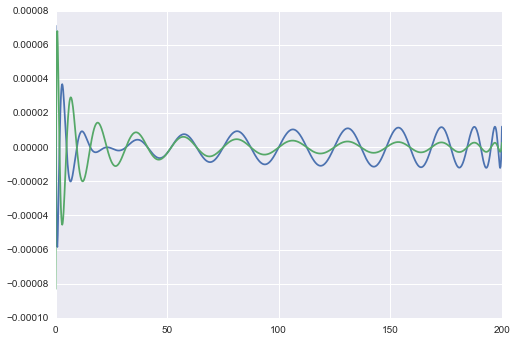

In [14]:
k_resids, c_resids = solution.evaluate_residual(ts)
plt.plot(ts, k_resids)
plt.plot(ts, c_resids)

plt.show()

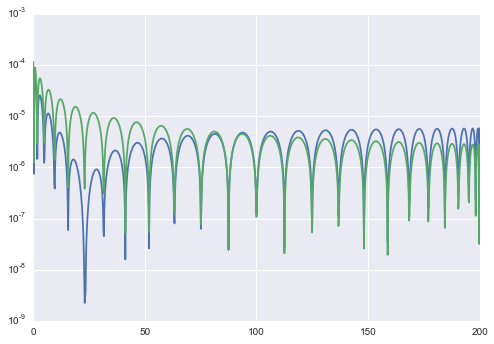

In [15]:
k_normalized_resids, c_normalized_resids = solution.normalize_residuals(ts)
plt.plot(ts, np.abs(k_normalized_resids))
plt.plot(ts, np.abs(c_normalized_resids))
plt.yscale('log')
plt.show()

<h3> B-spline basis functions </h3>

In [16]:
bspline_basis = pycollocation.basis_functions.BSplineBasis()
solver = pycollocation.solvers.Solver(bspline_basis)

boundary_points = (0, 200)
ts, ks, cs = initial_mesh(*boundary_points, num=250, problem=standard_ramsey_bvp)

tck, u = bspline_basis.fit([ks, cs], u=ts, k=5, s=0)
knots, coefs, k = tck
initial_coefs = np.hstack(coefs)

basis_kwargs = {'knots': knots, 'degree': k, 'ext': 2}
nodes = np.linspace(*boundary_points, num=249) 

solution = solver.solve(basis_kwargs, boundary_points, initial_coefs,
                        nodes, standard_ramsey_bvp)


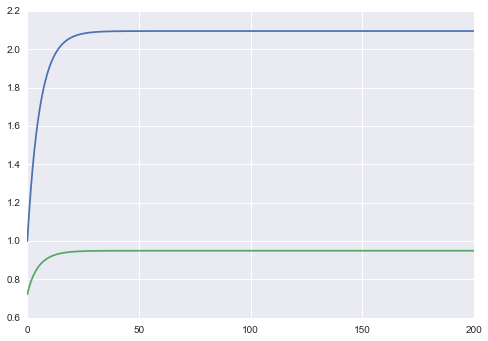

In [17]:
ts, _, _ = initial_mesh(*boundary_points, num=1000, problem=standard_ramsey_bvp)
k_soln, c_soln = solution.evaluate_solution(ts)
plt.plot(ts, k_soln)
plt.plot(ts, c_soln)
plt.show()

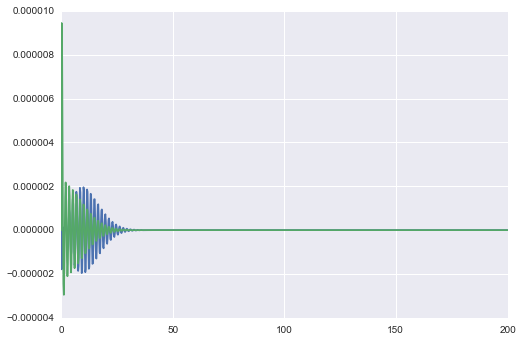

In [18]:
k_resids, c_resids = solution.evaluate_residual(ts)
plt.plot(ts, k_resids)
plt.plot(ts, c_resids)

plt.show()

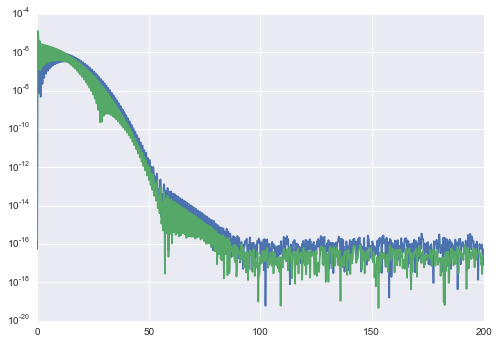

In [19]:
k_normalized_resids, c_normalized_resids = solution.normalize_residuals(ts)
plt.plot(ts, np.abs(k_normalized_resids))
plt.plot(ts, np.abs(c_normalized_resids))
plt.yscale('log')
plt.show()

<h1> Generic Ramsey-Cass-Koopmans model</h1>

Can we refactor the above code so that we can solve a Ramsey-Cass-Koopmans model for arbitrary $f$ and $u$? Yes!

In [20]:
from pycollocation.tests import models

Example usage...

In [21]:
def ces_output(k, alpha, l, sigma, **params):
    gamma = (sigma - 1) / sigma
    if gamma == 0:
        y = k**alpha * l**(1 - alpha)
    else:
        y = (alpha * k**gamma + (1 - alpha) * l**gamma)**(1 / gamma)
    return y


def ces_mpk(k, alpha, l, sigma, **params):
    y = ces_output(k, alpha, l, sigma)
    gamma = (sigma - 1) / sigma
    if gamma == 0:
        mpk = alpha * (y / k)
    else:
        mpk = alpha * k**(gamma - 1) * (y / (alpha * k**gamma + (1 - alpha) * l**gamma))
    return mpk


def ces_equilibrium_capital(a, alpha, b, delta, g, l, n, rho, sigma, **params):
    """Steady state value for capital stock (per unit effective labor)."""
    gamma = (sigma - 1) / sigma
    if gamma == 1:
        kss = ((a * alpha * l**(1 - alpha)) / (a * (delta + rho) + g))**(1 / (1 - alpha))
    else:
        kss = l * ((1 / (1 - alpha)) * (((a * (delta + rho) + g) / (a * alpha))**(gamma / (1 - gamma)) - alpha))**(-1 / gamma)
    return kss


In [27]:
ces_params = {'a': 0.5, 'b': 2.0, 'g': 0.02, 'n': 0.02, 'alpha': 0.15,
              'delta': 0.04, 'l': 1.0, 'K0': 5.0, 'A0': 1.0, 'N0': 1.0,
              'rho': 0.02, 'sigma': 3.5}

In [28]:
generic_ramsey_bvp = models.RamseyCassKoopmansModel(hara,
                                                    ces_output,
                                                    ces_equilibrium_capital,
                                                    ces_mpk,
                                                    ces_params)

In [29]:
polynomial_basis = pycollocation.basis_functions.PolynomialBasis()
solver = pycollocation.solvers.Solver(polynomial_basis)

boundary_points = (0, 500)
ts, ks, cs = initial_mesh(*boundary_points, num=1000, problem=standard_ramsey_bvp)

basis_kwargs = {'kind': 'Chebyshev', 'domain': boundary_points, 'degree': 25}
k_poly = polynomial_basis.fit(ts, ks, **basis_kwargs)
c_poly = polynomial_basis.fit(ts, cs, **basis_kwargs)
initial_coefs = np.hstack([k_poly.coef, c_poly.coef])
nodes = polynomial_basis.roots(**basis_kwargs)

solution = solver.solve(basis_kwargs, boundary_points, initial_coefs,
                        nodes, generic_ramsey_bvp)


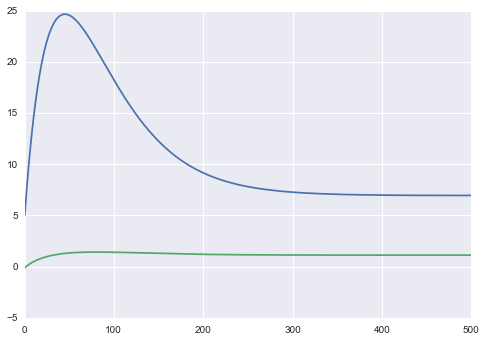

In [30]:
k_soln, c_soln = solution.evaluate_solution(ts)
plt.plot(ts, k_soln)
plt.plot(ts, c_soln)
plt.show()

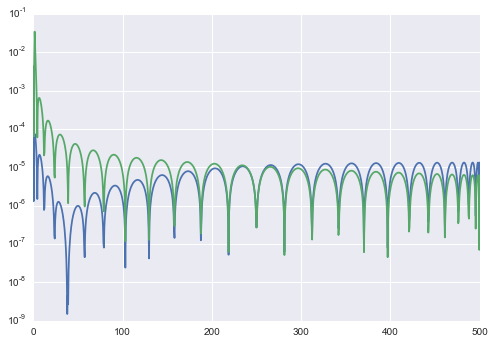

In [31]:
k_normalized_resids, c_normalized_resids = solution.normalize_residuals(ts)
plt.plot(ts, np.abs(k_normalized_resids))
plt.plot(ts, np.abs(c_normalized_resids))
plt.yscale('log')
plt.show()